In [1]:
%load_ext autoreload
%autoreload 2

import sys

sys.path.append("../")

import pickle
import time

import torch

import matplotlib.pyplot as plt
import defmod as dm
import model_graddesc as model

torch.set_default_tensor_type(torch.DoubleTensor)


#%%
dty = torch.float64
#source = torch.tensor([[-1., -1.], [1., 1.], [1., -1.], [-1., 1.]], requires_grad=True, dtype=dty)
#target = torch.tensor([[0., 0.], [2., 0.], [1., -1.], [1., 1.]], requires_grad=True, dtype=dty)

#target = torch.tensor([[-2., -2.], [2., 2.], [2., -2.], [-2., 2.]], requires_grad=True, dtype=dty)
#target = 1.+ torch.tensor([[-1., -1.], [1., 1.], [1., -1.], [-1., 1.]], requires_grad=True, dtype=dty)
def close_loop(oc):
    cc = np.zeros((np.shape(oc)[0]+1,2))
    cc[0:-1,:] = oc
    cc[-1][:] = oc[0][:]
    return cc
#%%


with open('../data/nuts/nutsdata.pickle', 'rb') as f:
    lines, sigv, sig = pickle.load(f)
source = torch.tensor(lines[0][::2], requires_grad=True, dtype=dty)[1:]

target = torch.tensor(lines[1][::2]  , requires_grad=True, dtype=dty)[1:]
num_target = 1

#target = torch.tensor(lines[7][::2]  , requires_grad=True, dtype=dty)[1:]
#num_target = 7

targets = [target]



pts_source = source.detach().numpy()
pts_target = target.detach().numpy()

#%%


sigma_scaling = 1.

#%%
#gd0 = torch.tensor([[-1., 0.6]], requires_grad=True, dtype=dty)
gd0 = torch.tensor([[-1., 0.]], requires_grad=True, dtype=dty)
cotan0 = torch.tensor([[0., 0.]], requires_grad=True, dtype=dty)
#gd1 = torch.tensor([[0.8, 0.6]], requires_grad=True, dtype=dty)
gd1 = torch.tensor([[1., 0.]], requires_grad=True, dtype=dty)
cotan1 = torch.tensor([[0., 0.]], requires_grad=True, dtype=dty)
#%%

In [16]:
scaling0 = dm.deformationmodules.LocalScaling(dm.manifold.Landmarks(2, 1, gd = gd0.view(-1), cotan = cotan0.view(-1)),sigma_scaling)
scaling1 = dm.deformationmodules.LocalScaling(dm.manifold.Landmarks(2, 1, gd = gd1.view(-1), cotan = cotan1.view(-1)), sigma_scaling)

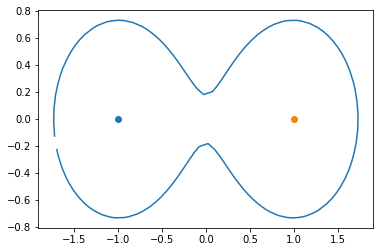

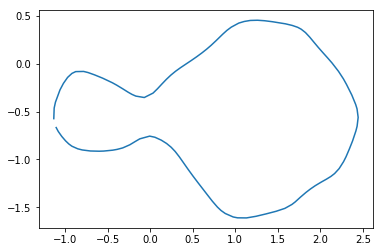

In [3]:
plt.figure()
plt.plot(pts_source[:,0], pts_source[:,1])
plt.scatter(gd0.detach().numpy()[:,0],gd0.detach().numpy()[:,1])
plt.scatter(gd1.detach().numpy()[:,0],gd1.detach().numpy()[:,1])

plt.show()

plt.figure()
plt.plot(pts_target[:,0], pts_target[:,1])
plt.show()


In [4]:
sigma_scaling = 1.
a = torch.sqrt(torch.tensor(3.))
direc_scaling_pts = torch.tensor([[1., 0.], [-0.5 , 0.5* a],  [-0.5, -0.5* a]], requires_grad=True, dtype=dty)
direc_scaling_vec =  torch.tensor([[1., 0.], [-0.5 , 0.5* a],  [-0.5, -0.5* a]], requires_grad=True, dtype=dty)
def f(x):
    centre = x.view(1,2).repeat(3,1)
    return centre + 0.3 * sigma_scaling * direc_scaling_pts

def g(x):
    return direc_scaling_vec
#%%
#gd0 = torch.tensor([[-1., 0.6]], requires_grad=True, dtype=dty)
gd0 = torch.tensor([[-1., 0.]], requires_grad=True, dtype=dty)
cotan0 = torch.tensor([[0., 0.]], requires_grad=True, dtype=dty)
#gd1 = torch.tensor([[0.8, 0.6]], requires_grad=True, dtype=dty)
gd1 = torch.tensor([[1., 0.]], requires_grad=True, dtype=dty)
cotan1 = torch.tensor([[0., 0.]], requires_grad=True, dtype=dty)
#%%
pts = f(gd0).detach().numpy()
vec = g(gd0).detach().numpy()
pts1 = f(gd1).detach().numpy()
vec1 = g(gd1).detach().numpy()


plt.quiver(pts[:,0], pts[:,1], vec[:,0], vec[:,1])
plt.quiver(pts1[:,0], pts1[:,1], vec1[:,0], vec1[:,1])
plt.plot(source.detach().numpy()[:,0], source.detach().numpy()[:,1], 'b')
plt.plot(target.detach().numpy()[:,0], target.detach().numpy()[:,1], 'r')
plt.axis('equal')
#%%
scaling0 = dm.deformationmodules.ConstrainedTranslations(dm.manifold.Landmarks(2, 1, gd = gd0.view(-1), cotan = cotan0.view(-1)), f, g, sigma_scaling)
scaling1 = dm.deformationmodules.ConstrainedTranslations(dm.manifold.Landmarks(2, 1, gd = gd1.view(-1), cotan = cotan1.view(-1)), f, g, sigma_scaling)


In [17]:
silent = dm.deformationmodules.SilentPoints(dm.manifold.Landmarks(2, len(source), gd=source.view(-1)))
#silent_comp = dm.deformationmodules.CompoundModule([silent])
trans = dm.deformationmodules.Translations(dm.manifold.Landmarks(2,1,gd = torch.tensor([0.,0.]).view(-1)), sigma=400, coeff=5.)
trans1 = dm.deformationmodules.Translations(dm.manifold.Landmarks(2, len(source), gd=source.view(-1)), sigma=0.2, coeff=10.)
mod = dm.deformationmodules.CompoundModule([silent, scaling0, scaling1, trans1, trans])
h = dm.hamiltonian.Hamiltonian(mod)

In [18]:
EnergyFunctional = model.EnergyFunctional_unconstrained(mod, h, source, targets, dim=2, gamma=0.01, attach=dm.attachement.VarifoldAttachement([1, 0.2]))

In [19]:
gd0_tensor = torch.cat(h.module.manifold.unroll_gd().copy(),0).requires_grad_().view(-1)
mom0_tensor = torch.cat(h.module.manifold.unroll_cotan().copy(),0).requires_grad_().view(-1)
    
    
gd0_tensor_init = gd0_tensor.clone()
gd0_tensor.retain_grad()
mom0_tensor.retain_grad()

In [20]:
def fun(P, *args):
    #EnergyFunctional = args[0]
    gd0_tensor = gd0_tensor_init.clone()
    Y = torch.tensor(P).requires_grad_()
    return EnergyFunctional.energy_tensor(gd0_tensor, Y).detach().numpy()

In [21]:
def jac(P):
    #EnergyFunctional = args[0]
    gd0_tensor = gd0_tensor_init.clone()
    Y = torch.tensor(P).requires_grad_()
    return EnergyFunctional.gradE_autograd(gd0_tensor, Y).detach().numpy()

In [22]:
P0 = mom0_tensor.detach().numpy()
fun(P0)

cost: [ 0.] attach: 12.933211334882209


array([ 12.93321133])

In [23]:
import scipy.optimize
res = scipy.optimize.minimize(fun, mom0_tensor.detach().numpy(),
                              method='BFGS',
                              jac=jac,
                              bounds=None,
                              tol=None,
                              callback=None,
                              options={
                                  'maxcor': 10,
                                  'ftol': 1.e-09,
                                  'gtol': 1e-03,
                                  'eps': 1e-08,
                                  'maxfun': 50,
                                  'maxiter': 20,
                                  'iprint': 1,
                                  'maxls': 25
                              })

/home/rosa/.local/share/miniconda2/envs/py3projects/lib/python3.6/site-packages/ipykernel_launcher.py:16: OptimizeWarning: Unknown solver options: maxcor, ftol, maxfun, iprint, maxls
  app.launch_new_instance()


cost: [ 0.] attach: 12.933211334882209
cost: [ 0.] attach: 12.933211334882209
cost: [ 0.26073254] attach: 38.61950180868973
cost: [ 0.26073254] attach: 38.61950180868973
cost: [ 0.01147588] attach: 6.9022241380191875
cost: [ 0.01147588] attach: 6.9022241380191875
cost: [ 0.29834895] attach: 36.6491209376524
cost: [ 0.29834895] attach: 36.6491209376524
cost: [ 0.01459034] attach: 6.009169124835472
cost: [ 0.01459034] attach: 6.009169124835472
cost: [ 0.02586031] attach: 5.7366307244891575
cost: [ 0.02586031] attach: 5.7366307244891575
cost: [ 0.03521708] attach: 5.238408088583065
cost: [ 0.03521708] attach: 5.238408088583065
cost: [ 0.06604394] attach: 4.261079939950227
cost: [ 0.06604394] attach: 4.261079939950227
cost: [ 0.40001108] attach: 1.8286407488925143
cost: [ 0.40001108] attach: 1.8286407488925143
cost: [ 0.57404856] attach: 1.1728072159968352
cost: [ 0.57404856] attach: 1.1728072159968352
cost: [ 0.45370733] attach: 0.6153171342322121
cost: [ 0.45370733] attach: 0.61531713423

In [24]:
P_opt = res.x
X = [gd0_tensor_init, torch.tensor(P_opt)]

In [25]:
%matplotlib inline
h.module.manifold.fill_gd(X[0])
h.module.manifold.fill_cotan(X[1])

In [26]:
states, controls = dm.shooting.shoot_euler(h, it=10)

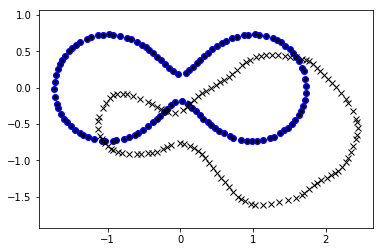

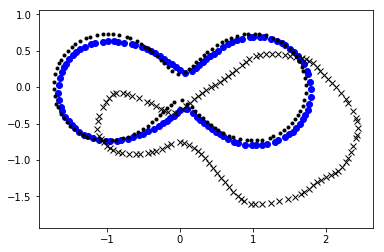

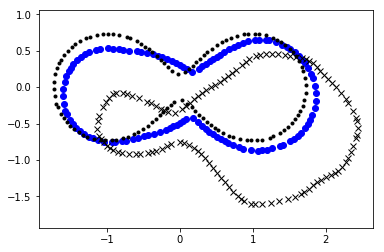

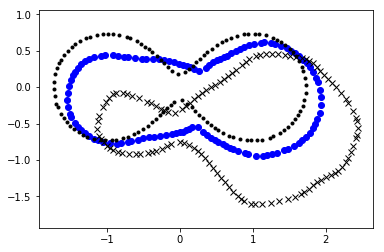

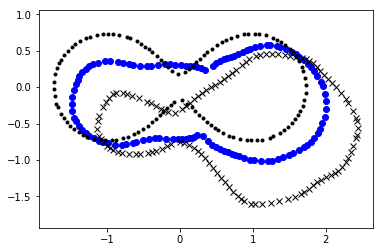

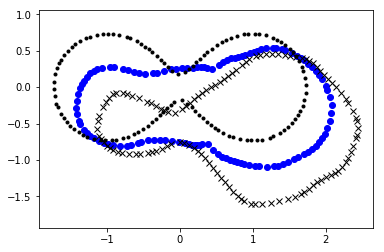

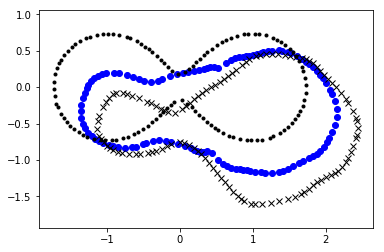

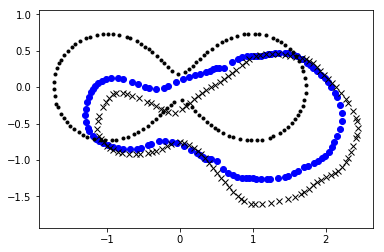

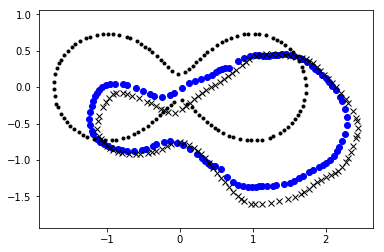

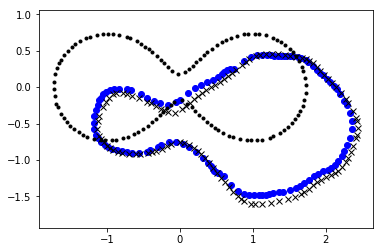

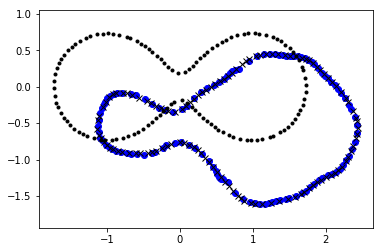

In [27]:
import numpy as np
import matplotlib.cm as cm
colors = cm.rainbow(np.linspace(0, 1, len(states)))

plt.figure()
for s,c in zip(states, colors):
    plt.figure()
    c = 'b'
    plt.scatter(s[0].gd.view(-1,2)[:, 0].detach().numpy(), s[0].gd.view(-1,2)[:, 1].detach().numpy(), c=c)
    #plt.scatter(s[1][-1].gd.view(-1,2)[:, 0].detach().numpy(), s[1][-1].gd.view(-1,2)[:, 1].detach().numpy(), c=c)
    #plt.scatter(s[2][0].gd.view(-1,2)[:, 0].detach().numpy(), s[2][0].gd.view(-1,2)[:, 1].detach().numpy(), c=c)
    #plt.scatter(s[2][1].gd.view(-1,2)[:, 0].detach().numpy(), s[2][1].gd.view(-1,2)[:, 1].detach().numpy(), c=c)
    plt.plot(targets[0][:, 0].detach().numpy(), targets[0][:, 1].detach().numpy(), 'xk')
    #plt.plot(target[1][:, 0].detach().numpy(), target[1][:, 1].detach().numpy(), 'xk')

    plt.plot(source[:, 0].detach().numpy(), source[:, 1].detach().numpy(), '.k')
    #plt.plot(source[1][:, 0].detach().numpy(), source[1][:, 1].detach().numpy(), '.k')


    plt.axis('equal')
    plt.show()

In [41]:
h.module.manifold.gd

[tensor([-1.1160, -0.6198, -1.1230, -0.5370, -1.1132, -0.4525, -1.0917, -0.3668,
         -1.0691, -0.2994, -1.0463, -0.2420, -1.0265, -0.2038, -0.9950, -0.1609,
         -0.9539, -0.1264, -0.9079, -0.1049, -0.8566, -0.0932, -0.7884, -0.0896,
         -0.6737, -0.1015, -0.6075, -0.1179, -0.4758, -0.1759, -0.3832, -0.2341,
         -0.2813, -0.2946, -0.2071, -0.3263, -0.0893, -0.3425,  0.0331, -0.3054,
          0.0925, -0.2622,  0.1925, -0.1590,  0.2867, -0.0725,  0.3720, -0.0217,
          0.4618,  0.0187,  0.5407,  0.0576,  0.6058,  0.1042,  0.6492,  0.1481,
          0.6829,  0.1861,  0.7150,  0.2159,  0.7524,  0.2349,  0.8092,  0.2430,
          0.9532,  0.3589,  1.0582,  0.4170,  1.1559,  0.4467,  1.2395,  0.4547,
          1.3087,  0.4500,  1.3649,  0.4402,  1.4109,  0.4307,  1.4576,  0.4234,
          1.5033,  0.4206,  1.5431,  0.4204,  1.5718,  0.4198,  1.6168,  0.4154,
          1.6602,  0.4073,  1.7218,  0.3868,  1.7527,  0.3723,  1.8130,  0.3341,
          1.8421,  0.3099,  

In [18]:
controls[3]

[tensor([], requires_grad=True),
 tensor([0.9479], grad_fn=<ViewBackward>),
 tensor([2.2717], grad_fn=<ViewBackward>),
 tensor([ 3.8307e-02, -3.5732e-04, -7.6192e-02,  8.0939e-03,  2.3137e-02,
         -8.1863e-03, -4.1032e-02, -1.7097e-03, -2.2161e-02, -4.0991e-03,
          1.8026e-01, -1.9159e-02, -3.5081e-01,  3.4882e-02,  3.6425e-01,
         -3.7432e-02, -3.8610e-01,  3.1745e-02,  2.1137e-01, -3.7624e-02,
         -4.8092e-02, -2.4717e-02, -1.3613e-01, -2.5485e-02,  2.1942e-01,
         -6.6410e-02, -2.5555e-01, -2.4455e-02,  1.5903e-01, -6.0725e-02,
         -7.5913e-02, -6.6784e-02, -1.5855e-01, -5.7934e-02,  3.0660e-01,
         -1.5239e-01, -2.7596e-01, -9.9804e-02,  2.0298e-01, -1.4509e-01,
          1.2362e-01, -9.9201e-02, -9.0347e-01,  5.3705e-02,  2.7928e+00,
         -2.5558e-01, -5.4556e+00,  5.4756e-01,  7.5411e+00, -7.2235e-01,
         -7.7217e+00,  7.5398e-01,  5.8315e+00, -5.8738e-01,  1.5671e-02,
         -7.7919e-03, -7.5660e+00,  7.9561e-01,  9.8110e+00, -8.679

In [ ]:
h.module.controls